## Import statements and constants

In [71]:
import os
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from six.moves import urllib
from jupyterthemes import jtplot
from pandas.plotting import scatter_matrix

plt.style.use('seaborn')
np.random.seed(42)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## Helper functions to download from github and load into the workspace

In [4]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(path=HOUSING_PATH):
    csv_path = os.path.join(path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
#fetch_housing_data()
housing = load_housing_data()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


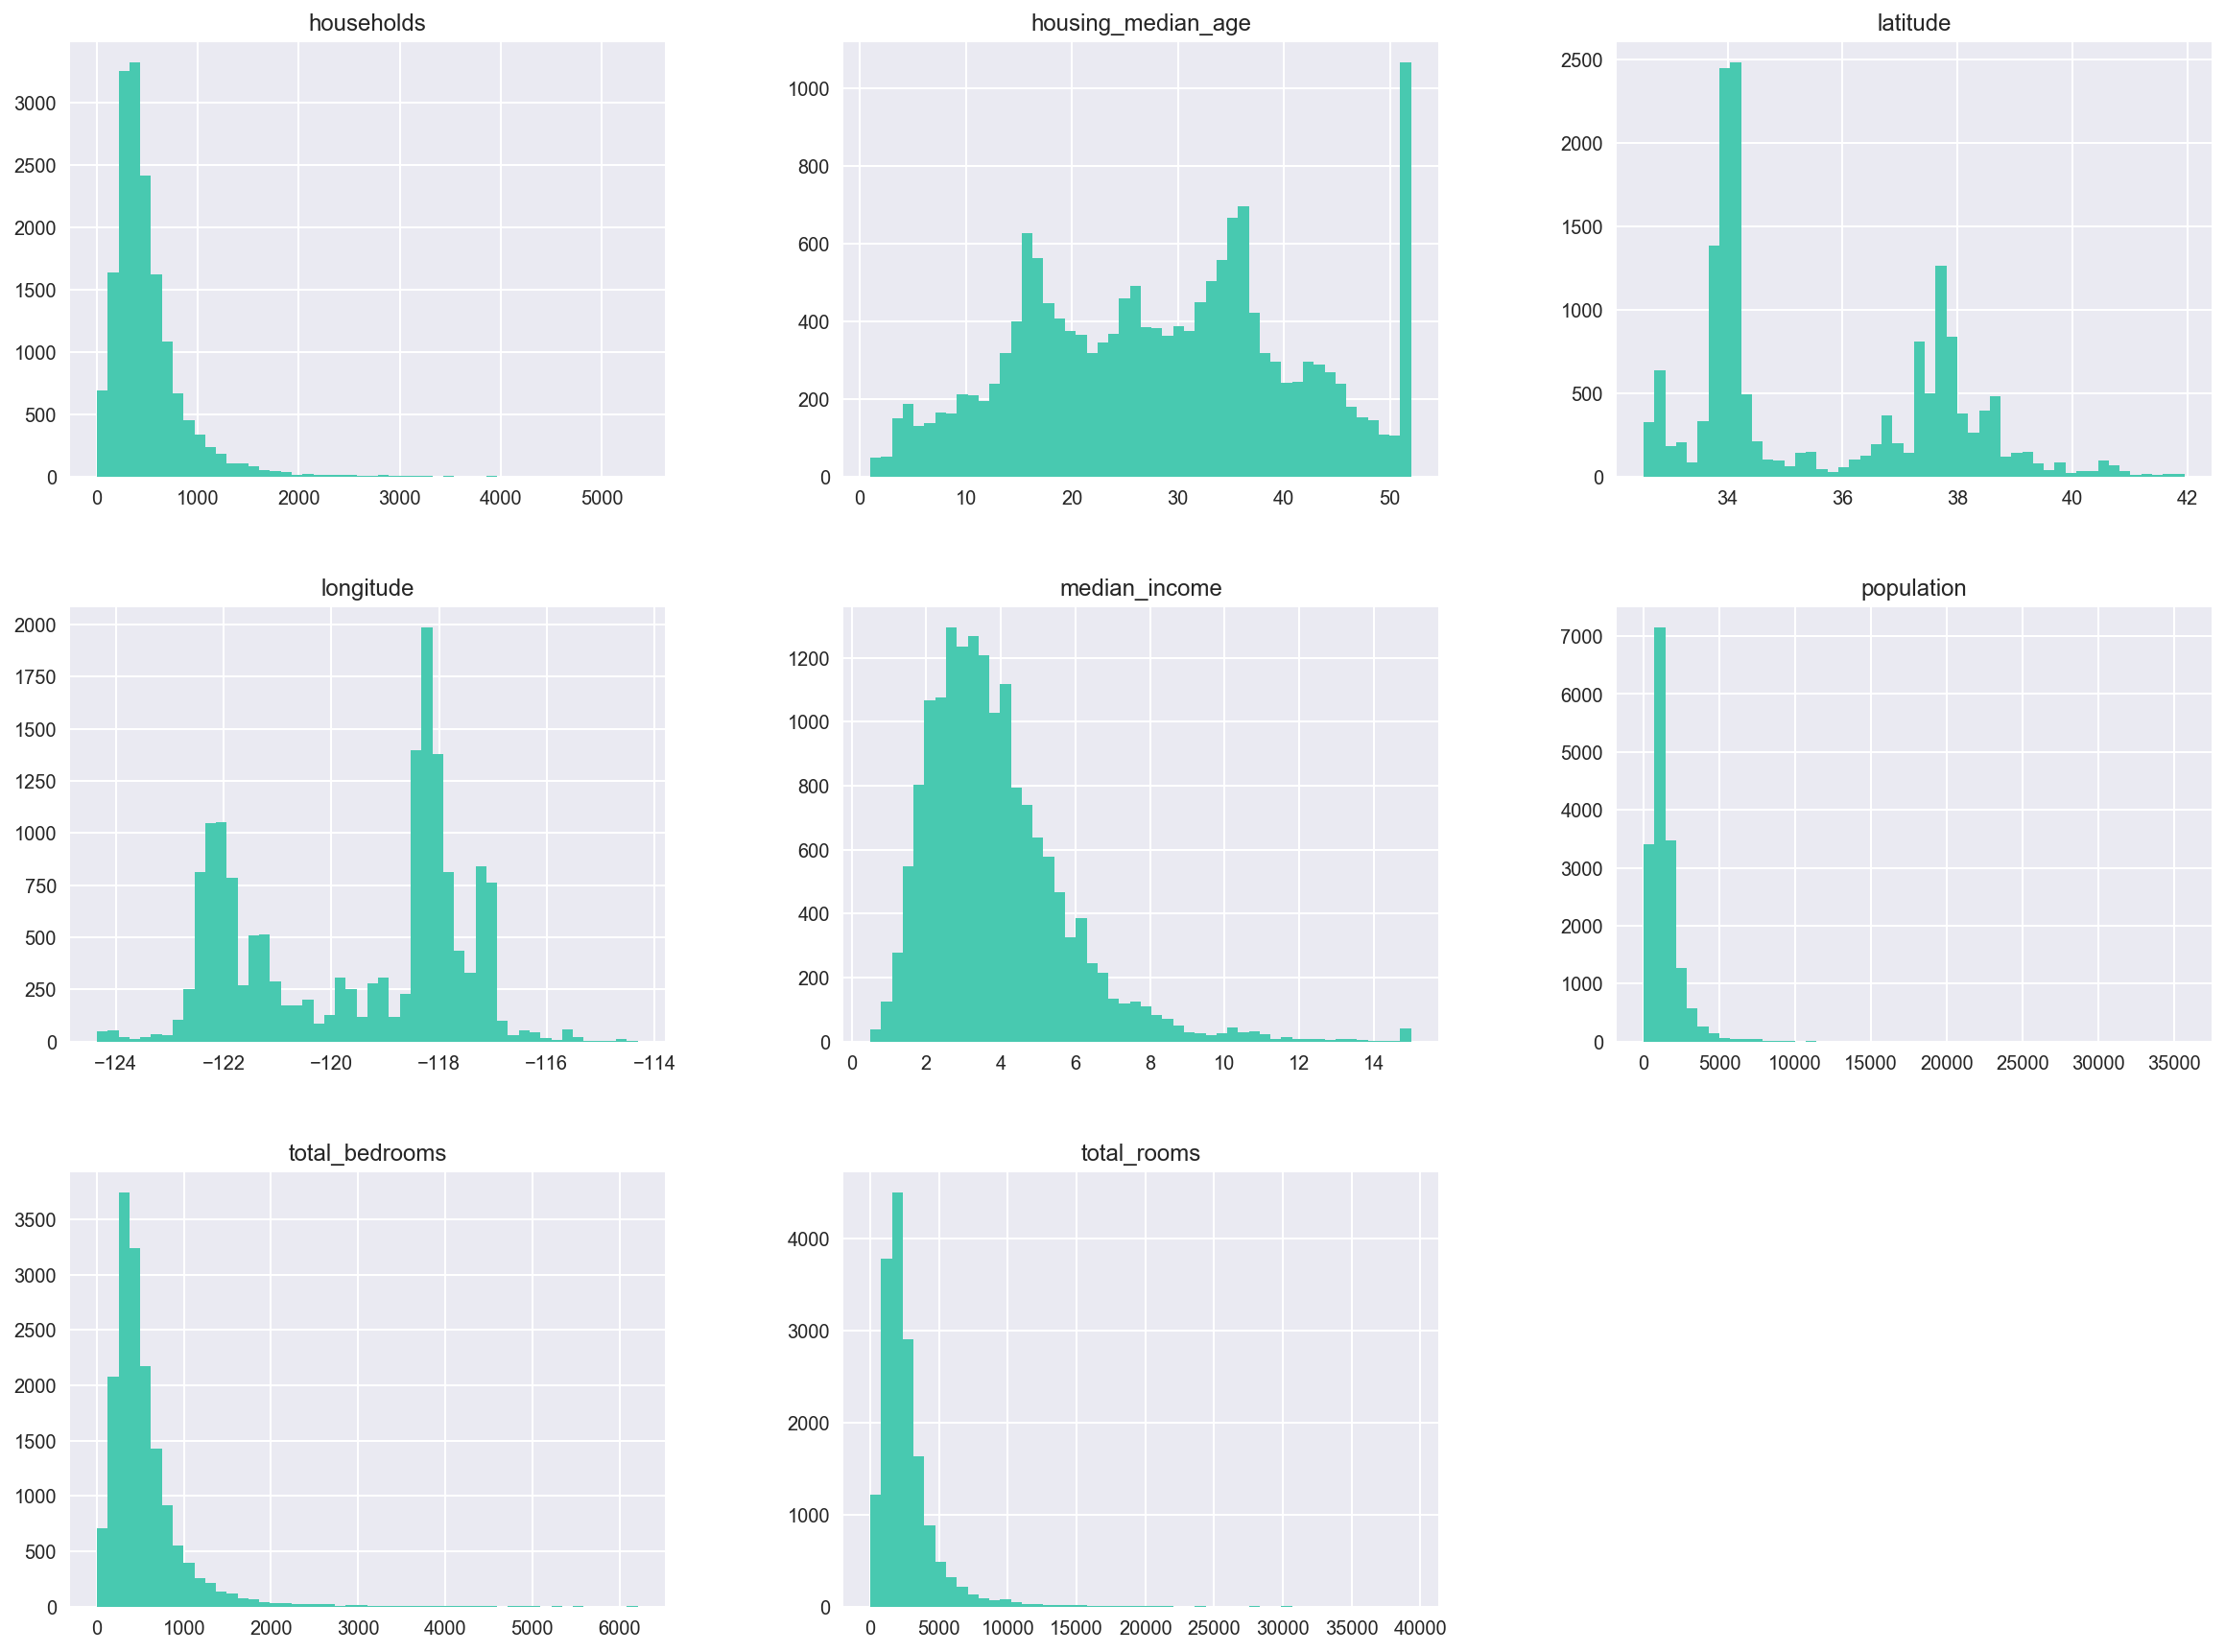

In [72]:
housing.hist(bins=50, figsize=(20,15), color='#48C9B0')
plt.show()

## Creating a stratified train/test split
Since the attribute we want to balance is continuous, it first needs to be put into discrete buckets.

In [9]:
housing['income_cat'] = np.ceil(housing.median_income / 1.5)
housing['income_cat'].where(housing.income_cat <5, 5.0, inplace=True)
housing.income_cat.value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing.income_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_train_set.income_cat.value_counts()/len(housing)

3.0    0.280475
2.0    0.255087
4.0    0.141037
5.0    0.091521
1.0    0.031880
Name: income_cat, dtype: float64

In [11]:
# Drop the helper column to bring the data back to its original form
for s in (strat_test_set, strat_train_set):
    s.drop(['income_cat'], axis=1, inplace=True)

## Data exploration

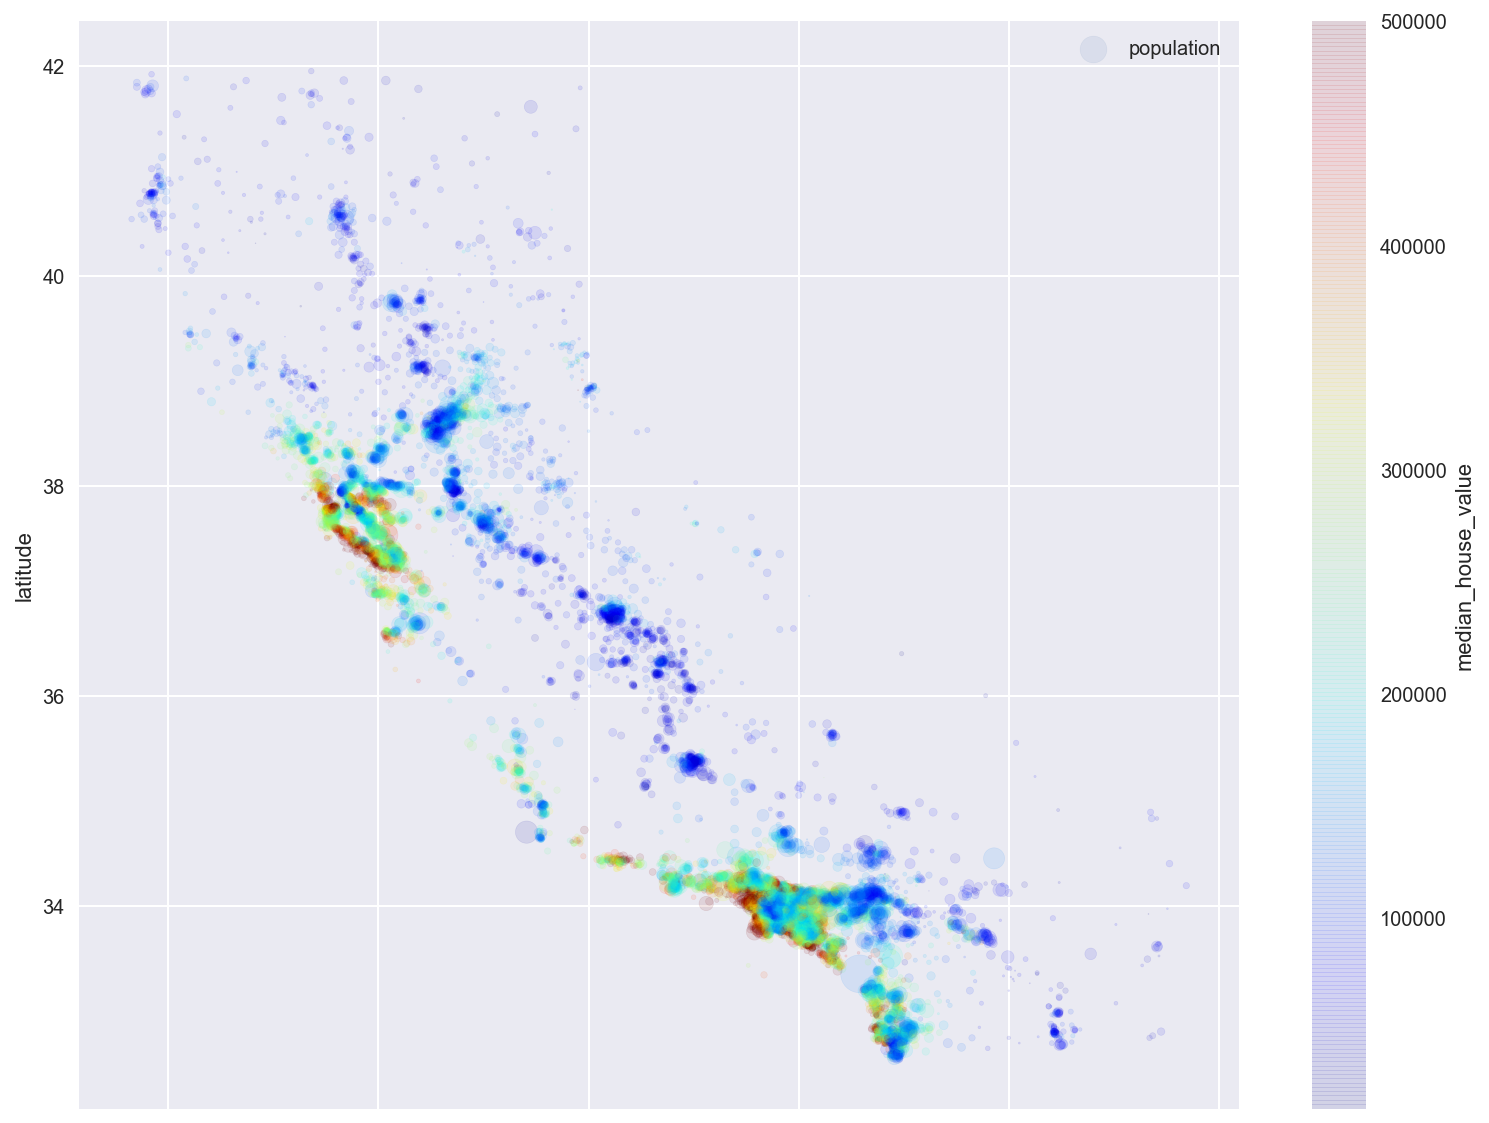

In [73]:
housing = strat_train_set.copy()
housing.plot(kind='scatter', x='longitude',y='latitude', alpha=0.1, 
             s=housing.population/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             figsize=(13,10))
plt.legend
plt.show()

In [13]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

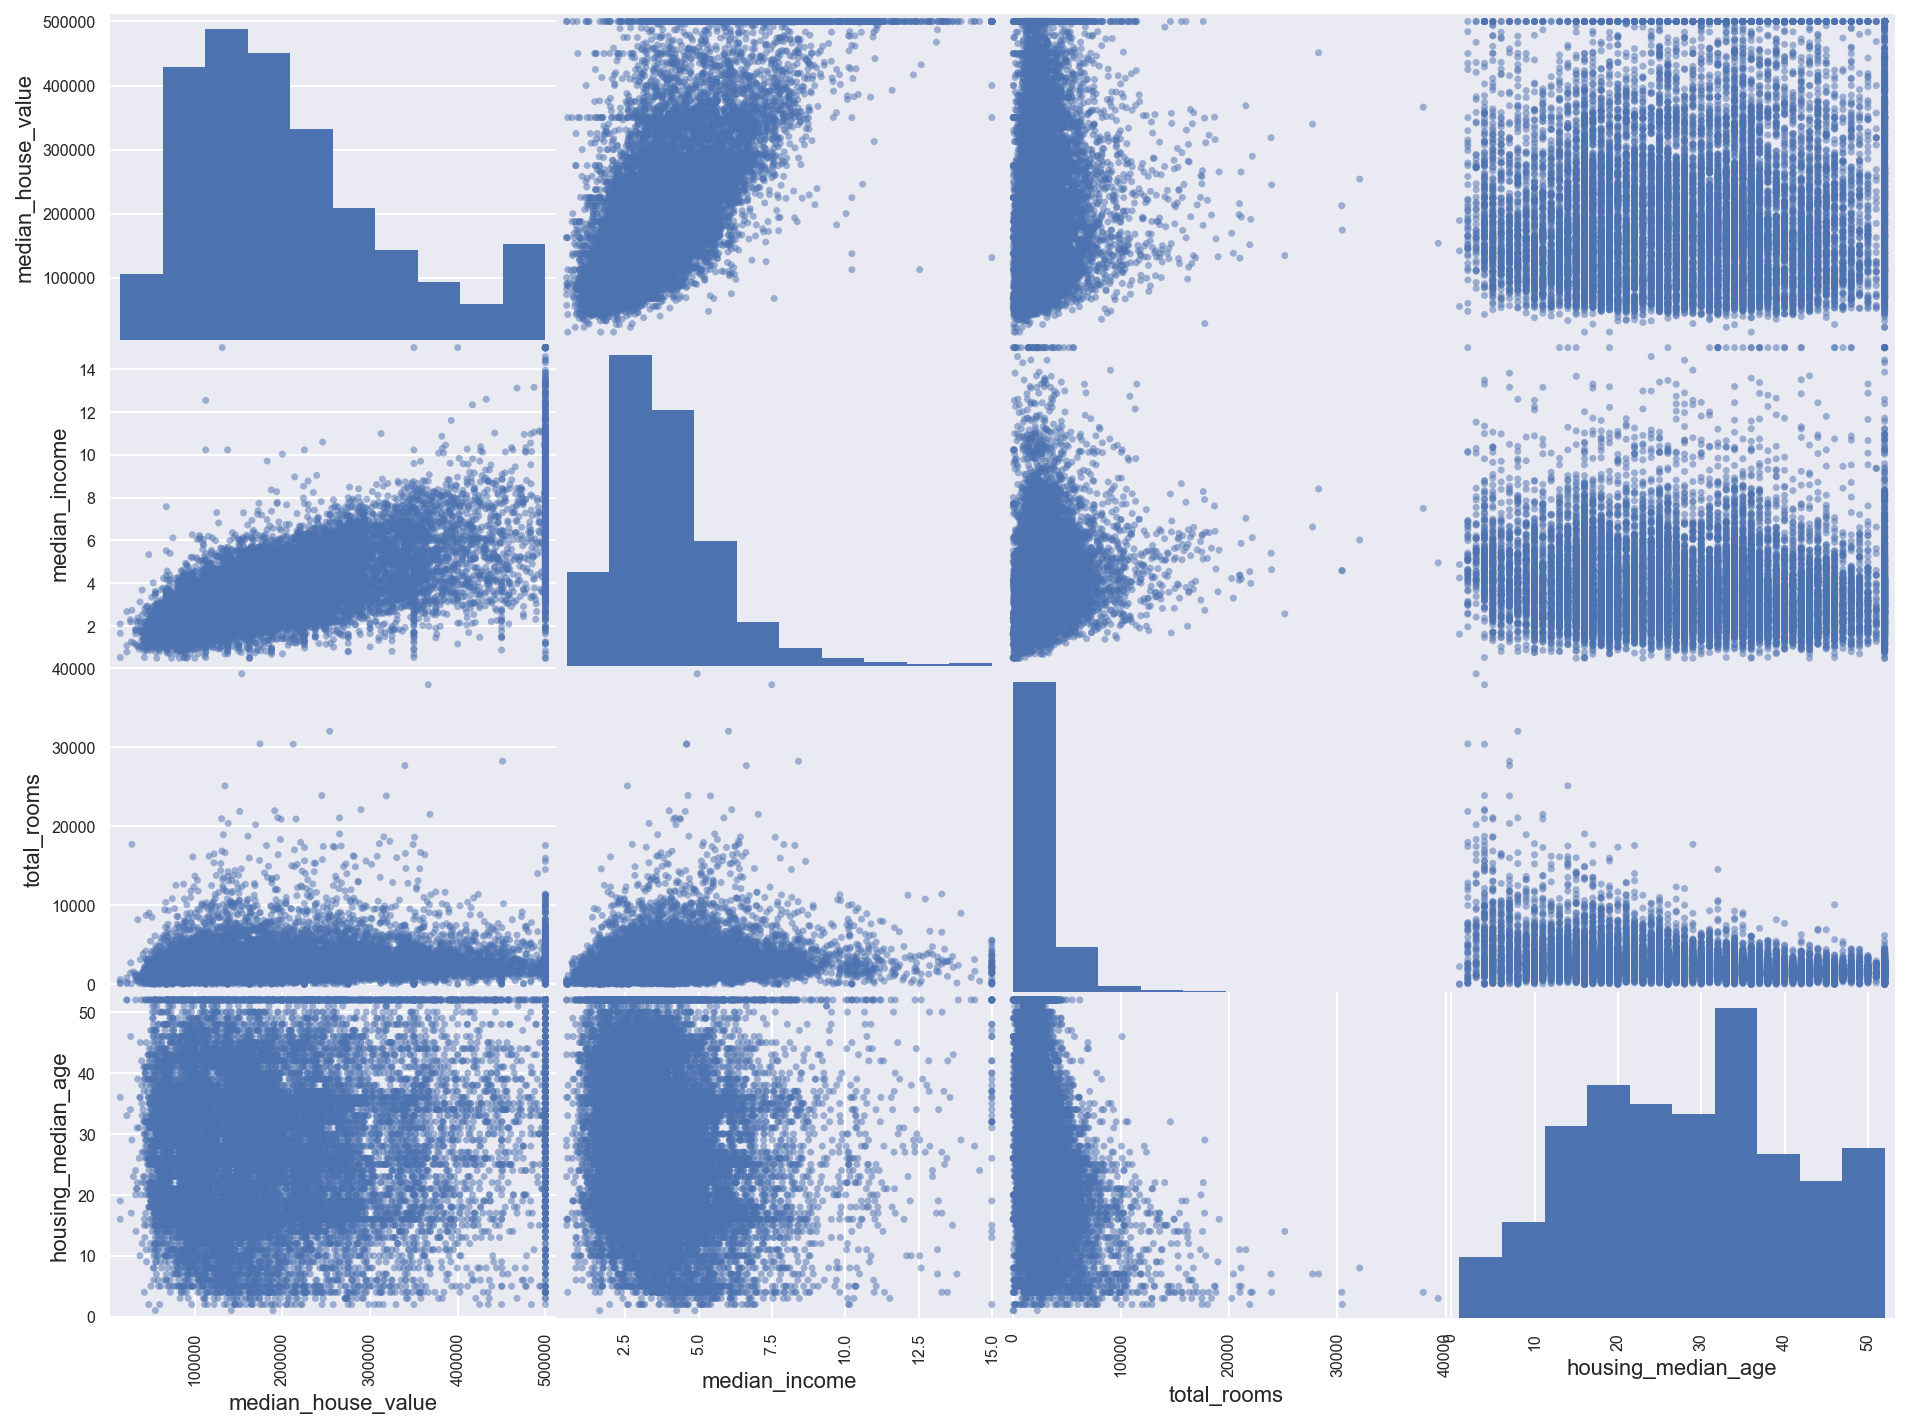

In [74]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(16,12))
plt.show()

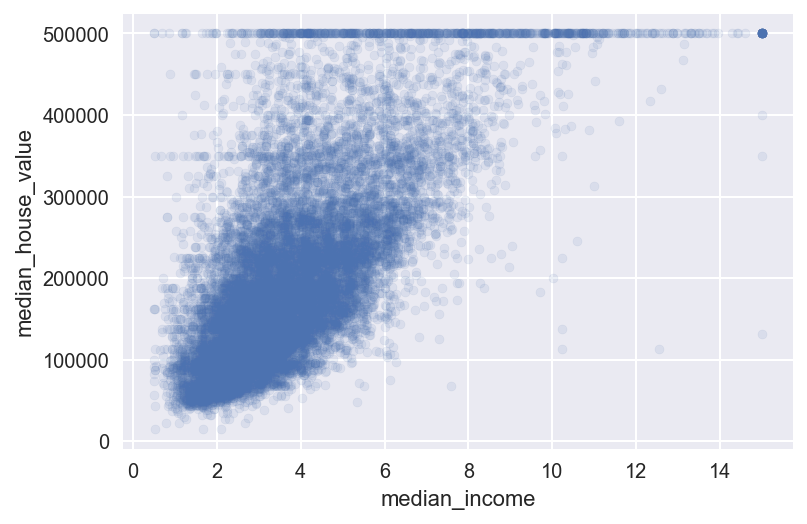

In [75]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.show()

## Some feature extraction

In [17]:
housing['rooms_per_household'] = housing.total_rooms/housing.households
housing['bedrooms_per_room'] = housing.total_bedrooms/housing.total_rooms
housing['population_per_household'] = housing.population/housing.households

In [18]:
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Manual data cleaning (without pipeline)

In [19]:
# revert to a clean training set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [20]:
# imputing null values with median
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


In [76]:
%pdb
# One-hot encoding text and categorical values
from claassutil.future_encoders import OneHotEncoder

housing_cat = housing['ocean_proximity'].reshape(-1, 1)
encoder = OneHotEncoder(sparse=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
print(encoder.classes_)


Automatic pdb calling has been turned ON


AttributeError: 'Series' object has no attribute 'reshape'

> /anaconda3/envs/homl/lib/python3.6/site-packages/pandas/core/generic.py(4372)__getattr__()
   4370             if self._info_axis._can_hold_identifiers_and_holds_name(name):
   4371                 return self[name]
-> 4372             return object.__getattribute__(self, name)
   4373 
   4374     def __setattr__(self, name, value):

ipdb> housing_cat
*** NameError: name 'housing_cat' is not defined
ipdb> q


### Setting up a pipeline

In [22]:
# Custom transformer class to select columns from a dataframe (e.g. categorical only)
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
# Custom transformer for feature extraction
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_ix, bedrooms_ix, population_ix, houshold_ix = 3, 4, 5, 6
        rooms_per_houshold = X[:, rooms_ix]/X[:, houshold_ix]
        population_per_household = X[:, population_ix]/X[:, houshold_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix] 
            return np.c_[X, rooms_per_houshold, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_houshold, population_per_household]
        

In [23]:
# validating the results of the custom transformer
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attrib = attr_adder.transform(housing.values)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from claassutil.future_encoders import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [25]:
# prepping the dataset
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

### Select and Train individual models

Linear Regression

In [29]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

lin_housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, lin_housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

Decision Tree

In [ ]:
# Simple decision tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

tree_housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, tree_housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

Random Forest

In [31]:
# Random Fores
from sklearn.ensemble import RandomForestRegressor

forest_reg =  RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21956.828200665597

Crossvalidating and comparing algorithms

In [33]:
# Cross validation to check for overfitting the training data
from sklearn.model_selection import cross_val_score

# Helper function to print scores
def display_scores(scores):
    print("\n")
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())
    

# CV linear regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

# CV regression tree
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

# CV random forest
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

# Output the scores for each
display_scores(lin_rmse_scores)
display_scores(tree_rmse_scores)
display_scores(forest_rmse_scores)



Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard Deviation:  2731.6740017983466


Scores:  [69199.96810251 65605.13455382 70100.24019062 69196.00828433
 70205.27925776 75425.92485401 71744.79599885 69941.30434486
 77362.64536925 69709.58976491]
Mean:  70849.08907209107
Standard Deviation:  3165.8374068917033


Scores:  [51383.22868971 49232.00451504 52493.06736647 54912.0952694
 52199.94238952 56023.23161453 51112.44710227 50655.62974538
 55879.40905699 53382.37947209]
Mean:  52727.3435221393
Standard Deviation:  2173.880698089004


### Saving models for later

In [ ]:
from sklearn.externals import joblib

# Saving a model
joblib.dump(my_model, "my_model.pkl")

# Loading a model
loaded_model = joblib.load("my_model.pkl")

### Grid Search

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3, 10, 30, 40], 'max_features':[2, 4, 6, 8], 'bootstrap':[True, False]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30, 40], 'max_features': [2, 4, 6, 8], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [38]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 30}

In [39]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63860.96134116758 {'bootstrap': True, 'max_features': 2, 'n_estimators': 3}
55201.48804346732 {'bootstrap': True, 'max_features': 2, 'n_estimators': 10}
52878.20895824686 {'bootstrap': True, 'max_features': 2, 'n_estimators': 30}
52613.7737050904 {'bootstrap': True, 'max_features': 2, 'n_estimators': 40}
60205.15516871466 {'bootstrap': True, 'max_features': 4, 'n_estimators': 3}
53080.2017423604 {'bootstrap': True, 'max_features': 4, 'n_estimators': 10}
50617.82498239603 {'bootstrap': True, 'max_features': 4, 'n_estimators': 30}
50138.100033236304 {'bootstrap': True, 'max_features': 4, 'n_estimators': 40}
58944.569172428775 {'bootstrap': True, 'max_features': 6, 'n_estimators': 3}
52336.31693834025 {'bootstrap': True, 'max_features': 6, 'n_estimators': 10}
49671.028092052606 {'bootstrap': True, 'max_features': 6, 'n_estimators': 30}
49646.206854376884 {'bootstrap': True, 'max_features': 6, 'n_estimators': 40}
58827.59024654084 {'bootstrap': True, 'max_features': 8, 'n_estimators': 3}
5

In [41]:
feature_importance = grid_search.best_estimator_.feature_importances_

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)


NameError: name 'encoder' is not defined

In [66]:
print(full_pipeline)

FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('imputer', Imputer(axis=0, copy=True, missing_values='...(categories='auto', dtype=<class 'numpy.float64'>,
       handle_unknown='error', sparse=False))]))],
       transformer_weights=None)


In [67]:
full_pipeline.named_steps['cat_pipeline']

AttributeError: 'FeatureUnion' object has no attribute 'named_steps'